In [3]:
import numpy as np
import sklearn
import pandas as pd
from sklearn import datasets
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
import math
from sklearn.metrics import r2_score
import json
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [4]:
def corr(x, y):
    up = sum(x*y)
    down = math.sqrt(sum(x*x)*sum(y*y))
    return up/down

class MGUA:
    def __init__(self, Q=3, C=0.99, I=3, model=LinearRegression(normalize=True), X_train=None, y_train=None, buf_coef=None, buf=None):
        self.Q = Q #размер буфера
        self.C = C #порог корреляции
        self.I = I #количество итераций
        self.model = model #model = LinearRegression(normalize=True)
        self.EPS = 1e-14
        self.X_train = X_train
        self.y_train = y_train
        self.buf_coef = buf_coef
        self.buf = buf
        
    def fit(self, X, y):
        N = X.shape[0]
        M = X.shape[1]
        buf_val = 0
        for i in range(M):
            print(i, ' / ', M)
            for j in range(i+1, M):
                X_train = X.iloc[:, [i, j]]
                self.model.fit(X_train, y)
                pred = self.model.predict(X_train) #Попробовать тут Х?
                if buf_val == 0:
#                     print(type(pred))
                    buf = [pred] #buf[0] = [pred]???
                    buf_coef = [[[i, j]]]
                    buf_val += 1
                else:
                    buf_corr = [corr(col, pred.reshape(-1, )) for col in buf[0].T]
                    if buf_val<self.Q and max(buf_corr)-self.C < self.EPS:
                        buf[0] = np.c_[buf[0], pred]
                        buf_coef[0].append([i, j])
                        buf_val += 1
                    elif buf_val>=self.Q and max(buf_corr)<self.C:
                        buf_r2 = [r2_score(y, buf[0][:, col]) for col in range(self.Q)]
                        if r2_score(y, pred) > min(buf_r2):
                            buf[0] = np.delete(buf[0], buf_r2.index(min(buf_r2)), axis = 1)
                            del buf_coef[0][buf_r2.index(min(buf_r2))]
                            buf[0] = np.c_[buf[0], pred]
                            buf_coef[0].append([i, j])

        for k in range(1, self.I):
            print("iter = ", k)
            buf_val = 0
            X_train = X.iloc[:, [0]]
            X_train = X_train.assign(new = buf[k-1][:, 0])
            self.model.fit(X_train, y)
            pred = self.model.predict(X_train) 
            
            buf.append(pred)
            buf_coef.append([[0, 0]])
            buf_val += 1
            for i in range(M):
#                 print('i = ', i)
                for j in range(1, buf[k-1].shape[1]):
                    X_train = X.iloc[:, [i]]
                    X_train = X_train.assign(new = buf[k-1][:, j])
                    self.model.fit(X_train, y)
                    pred = self.model.predict(X_train) 

                    buf_corr = [corr(col, pred.reshape(-1, )) for col in buf[k].T]
#                     if buf_val>=self.Q:
#                         print('buf_val=', buf_val, 'max(buf_corr)=', max(buf_corr), max(buf_corr)<self.C)
                    if buf_val<self.Q and max(buf_corr)-self.C < self.EPS:
#                         print('1. (i, j) = ', i, j)
                        buf[k] = np.c_[buf[k], pred]
                        buf_coef[k].append([i, j])
                        buf_val += 1
                    elif buf_val>=self.Q and max(buf_corr)<self.C:
                        buf_r2 = [r2_score(y_train, buf[k][:, col]) for col in range(self.Q)]
                        if r2_score(y_train, pred) > min(buf_r2):
#                             print('(i, j) = ', i, j)
                            buf[k] = np.delete(buf[k], buf_r2.index(min(buf_r2)), axis = 1)
                            del buf_coef[k][buf_r2.index(min(buf_r2))]
                            buf[k] = np.c_[buf[k], pred]
                            buf_coef[k].append([i, j])
        self.buf_coef = buf_coef
        self.buf = buf
        self.X_train = X
        self.y_train = y
        return buf_coef
    
    def predict(self, X):
        result = []
        index = []
        for i in range(len(self.buf_coef[-1])): #может быть последний буфер не полностью заполнен, тогда меньше...
            ind_pred = i
            index.append([])
            for k in reversed(range(self.I)):
                index[i].append(self.buf_coef[k][ind_pred])
                ind_pred = self.buf_coef[k][ind_pred][1]
            X_t = self.X_train.iloc[:, index[i][-1]]
            self.model.fit(X_t, self.y_train)
            pred = self.model.predict(X.iloc[:, index[i][-1]])
            for k in range(1, self.I):
                X_t = self.X_train.iloc[:, [index[i][self.I-1-k][0]]]
                X_t = X_t.assign(new = self.buf[k-1][:, index[i][self.I-1-k][1]])
                self.model.fit(X_t, self.y_train)
                X_pred = X.iloc[:, [index[i][self.I-1-k][0]]]
                X_pred = X_pred.assign(new = pred)
                pred = self.model.predict(X_pred)
            result.append(pred)
            
        return result #Q столбцов - Q предсказаний
    
    def save_json(self, filepath):
        dict_ = {}
        dict_['Q'] = self.Q
        dict_['C'] = self.C
        dict_['I'] = self.I
#         dict_['model'] = self.model
        dict_['X_train'] = self.X_train.to_numpy().tolist() if self.X_train is not None else 'None'
        dict_['y_train'] = self.y_train.to_numpy().tolist() if self.y_train is not None else 'None'
        dict_['buf_coef'] = np.array(self.buf_coef).tolist() if self.buf_coef is not None else 'None'
        dict_['buf'] = np.array(self.buf).tolist() if self.buf is not None else 'None'
        
        # Creat json and save to file
        json_txt = json.dumps(dict_, indent=4)
        with open(filepath, 'w') as file:
            file.write(json_txt)
            
            
    # A method for loading data from JSON file
    def load_json(self, filepath):
        with open(filepath, 'r') as file:
            dict_ = json.load(file)
            
        self.Q = dict_['Q']
        self.C = dict_['C']
        self.I = dict_['I']
#         self.model = dict_['model']
        self.X_train = pd.DataFrame(dict_['X_train']) if dict_['X_train'] != 'None' else None
        self.y_train = pd.DataFrame(dict_['y_train']) if dict_['y_train'] != 'None' else None
        self.buf_coef = np.asarray(dict_['buf_coef']) if dict_['buf_coef'] != 'None' else None
        self.buf = np.asarray(dict_['buf']) if dict_['buf'] != 'None' else None
        



## Как сохранить обученную модель:

In [ ]:
filepath = "mylogreg.json"

# Create a model and train it
mylogreg = MGUA(X_train=Xtrain, Y_train=Ytrain)
mylogreg.save_json(filepath)

# Create a new object and load its data from JSON file
json_mylogreg = MGUA()
json_mylogreg.load_json(filepath)
json_mylogreg

In [8]:
glass = pd.read_csv('glass_/GLASS_matrix_alphabet_NNdt*_1and2and3chains.csv', sep=',', header=None)
y_glass = pd.read_csv('glass_/GLASS_y.csv')

In [9]:
mgua = MGUA(Q=4, C=0.997, I=5, model=LinearRegression(normalize=True))

In [11]:
train_size = int(0.7 * glass.shape[0])

X_train = glass[:][:train_size]
y_train = y_glass[:][:train_size]
X_test = glass[:][train_size:]
y_test = y_glass[:][train_size:]
coef = mgua.fit(X_train, y_train)

In [12]:
res = mgua.predict(X_test)

In [13]:
for i in range(4):
    print(r2_score(y_test, res[i]))

0.9287023586642775
0.8399777455671995
0.829126991426675
0.7829653377845821


In [14]:
mgua.buf_coef

[[[0, 6], [0, 35], [2, 6], [6, 55]],
 [[1, 2], [1, 3], [2, 3], [17, 3]],
 [[0, 0], [0, 1], [0, 3], [2, 2]],
 [[0, 0], [0, 1], [0, 2], [2, 3]],
 [[0, 0], [0, 1], [0, 2], [2, 3]]]

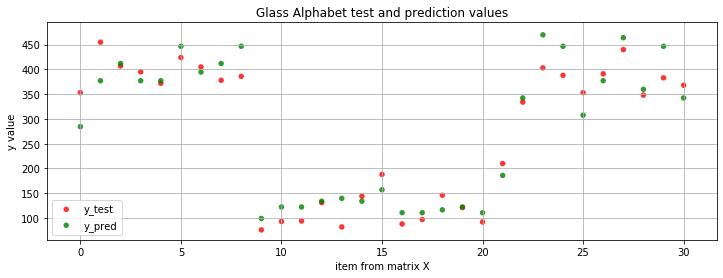

In [16]:
data = ((np.arange(y_test.shape[0]), y_test.to_numpy().reshape(-1)), (np.arange(y_test.shape[0]), res[0].reshape(-1)))
colors = ("red", "green")
groups = ("y_test", "y_pred")

# Create plot
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(4)

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Glass Alphabet test and prediction values')
plt.ylabel("y value")
plt.xlabel("item from matrix X")
plt.grid()  
plt.legend(loc=0)
plt.show()